In [1]:

import zipfile
import os
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import requests
import xml.etree.ElementTree as ET
import tensorflow as t
import torch
import torch.nn as nn

2024-06-27 21:17:25.802867: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-27 21:17:27.820869: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Unzipping csv file

In [2]:

uploaded_zip = '/home/claney/EclipsePlatform/eclipse_platform.zip'
extract_dir = '/home/claney/extracted'
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)
with zipfile.ZipFile(uploaded_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

csv_file = os.path.join(extract_dir, 'eclipse_platform.csv')
full_df = pd.read_csv(csv_file)

# Fill NAN

In [3]:
full_df.fillna(0,inplace=True)

# Spliting testing and training

In [4]:
length=len(full_df)
split_index=int(.8*length)
df=full_df.iloc[:split_index] #df=training set

# Creating full_text_data column

In [5]:
#creating freeform textual data column
df['full_text_data']=df['Description']+df['Title']
print(df['full_text_data'])
df['full_text_data']=df['full_text_data'].fillna('')

0        - Setup a project that contains a *.gif resour...
1        Opening repository resource always open the de...
2        KM (10/2/2001 5:55:18 PM); \tThis PR about the...
3        - become synchronized with some project in a r...
4        For getting/setting the managed state of a res...
                               ...                        
68119    Build ID: 3.3 (I am not sure what You mean by ...
68120    There are several NPEs within the UI session t...
68121    I20080501-0100; ; Now that were using the coll...
68122    Created attachment 98318; screenshot; ; I20080...
68123    Build ID: M20080221-1800; ; Steps To Reproduce...
Name: full_text_data, Length: 68124, dtype: object


/tmp/ipykernel_200549/3345744263.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_text_data']=df['Description']+df['Title']
/tmp/ipykernel_200549/3345744263.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_text_data']=df['full_text_data'].fillna('')


# Creating isDuplicate column

In [6]:
def is_duplicate(val):
    return 1 if val !=0.0 else 0
df['isDuplicate'] = df['Duplicated_issue'].apply(lambda x: is_duplicate(x))

print(df['isDuplicate'])

0        0
1        0
2        0
3        0
4        0
        ..
68119    0
68120    0
68121    0
68122    0
68123    0
Name: isDuplicate, Length: 68124, dtype: int64


/tmp/ipykernel_200549/1537637410.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['isDuplicate'] = df['Duplicated_issue'].apply(lambda x: is_duplicate(x))


In [7]:
df.head()

,Issue_id,Priority,Component,Duplicated_issue,Title,Description,Status,Resolution,Version,Created_time,Resolved_time,full_text_data,isDuplicate
0,1,P3,Team,0.0,Usability issue with external editors (1GE6IRL),- Setup a project that contains a *.gif resour...,CLOSED,FIXED,2.0,2001-10-10 21:34:00 -0400,2012-02-09 15:57:47 -0500,- Setup a project that contains a *.gif resour...,0
1,2,P5,Team,0.0,Opening repository resources doesnt honor type...,Opening repository resource always open the de...,RESOLVED,FIXED,2.0,2001-10-10 21:34:00 -0400,2002-05-07 10:33:56 -0400,Opening repository resource always open the de...,0
2,3,P5,Team,0.0,Sync does not indicate deletion (1GIEN83),KM (10/2/2001 5:55:18 PM); \tThis PR about the...,RESOLVED,FIXED,2.0,2001-10-10 21:34:00 -0400,2010-05-07 10:28:53 -0400,KM (10/2/2001 5:55:18 PM); \tThis PR about the...,0
3,4,P5,Team,0.0,need better error message if catching up over ...,- become synchronized with some project in a r...,RESOLVED,FIXED,2.0,2001-10-10 21:34:00 -0400,2002-03-01 16:27:31 -0500,- become synchronized with some project in a r...,0
4,5,P3,Team,0.0,ISharingManager sharing API inconsistent (1GAU...,For getting/setting the managed state of a res...,RESOLVED,WONTFIX,2.0,2001-10-10 21:34:00 -0400,2008-08-15 08:04:36 -0400,For getting/setting the managed state of a res...,0


# Splitting training into training and testing for models 

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X = df['full_text_data']  # Input features
y = df['isDuplicate']       # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# GPU setup

In [11]:
# Check for CUDA availability
if torch.cuda.is_available():
    print("CUDA is available. Number of GPUs:", torch.cuda.device_count())
    print("CUDA device name:", torch.cuda.get_device_name(4))
else:
    print("CUDA is not available.")
torch.cuda.set_device(torch.device("cuda:4"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


CUDA is available. Number of GPUs: 8
CUDA device name: NVIDIA GeForce GTX 1080 Ti


## MLP neural network

In [10]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


In [16]:
X = df['full_text_data']  # Input features
y = df['isDuplicate']       # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=1000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# neural net
model1 = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=1000)
nn.ModuleList
model1.fit(X_train_vec, y_train)

# Make predictions on the test set
y_pred = model1.predict(X_test_vec)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)


Test Accuracy: 0.7445246902706829


In [21]:
X = df['full_text_data']+df['Component']  # Input features
y = df['isDuplicate']       # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=1000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# neural net
model1 = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=1000)
nn.ModuleList
model1.fit(X_train_vec, y_train)

# Make predictions on the test set
y_pred = model1.predict(X_test_vec)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.7513945158828019


In [22]:
X = df['full_text_data']+df['Component']  # Input features
y = df['isDuplicate']       # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=1000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# neural net
model1 = MLPClassifier(hidden_layer_sizes=(32, 16), activation='relu', max_iter=1000)
nn.ModuleList
model1.fit(X_train_vec, y_train)

# Make predictions on the test set
y_pred = model1.predict(X_test_vec)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.7062415595091304


In [28]:
X = df['full_text_data']+df['Component']  # Input features
y = df['isDuplicate']       # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=1000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# neural net
model1 = MLPClassifier(hidden_layer_sizes=(128, 64), activation='tanh', max_iter=1000)
model1.fit(X_train_vec, y_train)

# Make predictions on the test set
y_pred = model1.predict(X_test_vec)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.732311666960249


In [24]:
X = df['Component']  # Input features
y = df['isDuplicate']       # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=1000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# neural net
model1 = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=1000)
nn.ModuleList
model1.fit(X_train_vec, y_train)

# Make predictions on the test set
y_pred = model1.predict(X_test_vec)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.8256121190769773


# BERT trasformer model

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast


In [34]:
pip install transformers tensorflow


Note: you may need to restart the kernel to use updated packages.


In [ ]:
device = torch.device("cuda:4")

In [1]:

# Load model directly
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = AutoModelForMaskedLM.from_pretrained("google-bert/bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/home/claney/anaconda3/envs/reu/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at google-bert/bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
from sklearn.model_selection import train_test_split
from transformers import AutoModel, BertTokenizerFast

In [10]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['full_text_data'], df['isDuplicate'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['isDuplicate'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [11]:

# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

<Axes: >

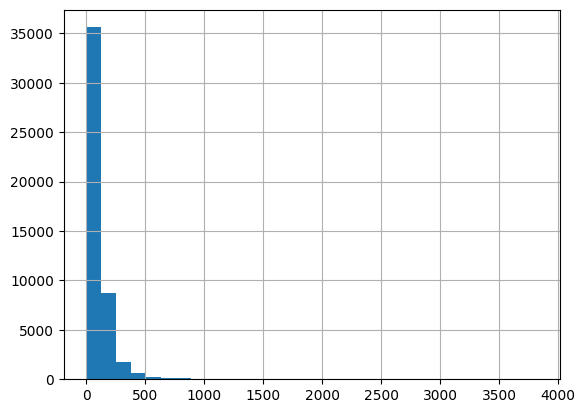

In [12]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [13]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

/home/claney/anaconda3/envs/reu/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [47]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [15]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [16]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [17]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        
        self.bert = bert 
        
        # dropout layer
        self.dropout = nn.Dropout(0.1)
      
        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)
      
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
        
        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)
      
        # apply softmax activation
        x = self.softmax(x)

        return x

In [19]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)



In [20]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5) 

/home/claney/anaconda3/envs/reu/lib/python3.11/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Assuming train_labels is defined and is a numpy array or list
# Compute the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)

print("Class Weights:", class_weights)


Class Weights: [0.60687742 2.83912836]


In [24]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
#weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [60]:
# function to train the model
def train():
    
    model.train()
    total_loss, total_accuracy = 0, 0
  
    # empty list to save model predictions
    total_preds=[]
  
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
        
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        
        # push the batch to gpu
        #batch = [r.to(device) for r in batch]
 
        sent_id, mask, labels = batch
        
        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        #preds=preds.detach().cpu().numpy()
        preds=preds.detach().numpy()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
  
      # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [61]:
# function for evaluating the model
import time
def evaluate():
    
    print("\nEvaluating...")
  
    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0
    
    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):
        
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = time.time()
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        #batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():
            
            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            #preds = preds.detach().cpu().numpy()
            preds = preds.detach().numpy()
            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [34]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        #torch.save('saved_weights.pt')
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of  1,491.
  Batch   100  of  1,491.
  Batch   150  of  1,491.
  Batch   200  of  1,491.
  Batch   250  of  1,491.
  Batch   300  of  1,491.
  Batch   350  of  1,491.
  Batch   400  of  1,491.
  Batch   450  of  1,491.
  Batch   500  of  1,491.
  Batch   550  of  1,491.
  Batch   600  of  1,491.
  Batch   650  of  1,491.
  Batch   700  of  1,491.
  Batch   750  of  1,491.
  Batch   800  of  1,491.
  Batch   850  of  1,491.
  Batch   900  of  1,491.
  Batch   950  of  1,491.
  Batch 1,000  of  1,491.
  Batch 1,050  of  1,491.
  Batch 1,100  of  1,491.
  Batch 1,150  of  1,491.
  Batch 1,200  of  1,491.
  Batch 1,250  of  1,491.
  Batch 1,300  of  1,491.
  Batch 1,350  of  1,491.
  Batch 1,400  of  1,491.
  Batch 1,450  of  1,491.

Evaluating...
  Batch    50  of    320.
  Batch   100  of    320.
  Batch   150  of    320.
  Batch   200  of    320.
  Batch   250  of    320.
  Batch   300  of    320.

Training Loss: 0.690
Validation Loss: 0.694

 Epoch 2 / 10


In [35]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [44]:
# Get predictions for test data
with torch.no_grad():
    preds = model(test_seq, test_mask)
    preds = preds.detach().numpy()


In [54]:
from sklearn.metrics import classification_report

# Assuming preds is the predictions from your model and test_y is the ground truth labels

# Convert predictions to class labels (assuming preds are probabilities or logits)
# Assuming preds is a 2D array where each row corresponds to predictions for one sample
predicted_classes = np.argmax(preds, axis=1)
# Generate classification report
report = classification_report(test_y, predicted_classes)
print(report)




              precision    recall  f1-score   support

           0       0.86      0.61      0.72      8419
           1       0.22      0.52      0.31      1800

    accuracy                           0.60     10219
   macro avg       0.54      0.57      0.51     10219
weighted avg       0.75      0.60      0.64     10219



# Naive Bayes

In [66]:
X = df['Component']  # Input features
y = df['isDuplicate']       # Target variable

In [67]:
n = len(df)
split_index = int(.8 * n)
train_dataset = df.iloc[:split_index]
validation_dataset = df.drop(train_dataset.index)

In [68]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [69]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords #Word Stop
from nltk.tokenize import word_tokenize #Tokenization & Word Stop"

In [70]:
train_target = train_dataset['isDuplicate']  # target features
#topic_train_priority
train_feature = train_dataset['full_text_data']       # input variable
#topic_train_data
validation_target= validation_dataset['isDuplicate']  # feature features
#topic_validation_priority
validation_feature= validation_dataset['full_text_data']       # input variable
#topic_validation_data 


In [71]:
vectorizer = CountVectorizer(stop_words = 'english', tokenizer = word_tokenize, lowercase = True)
train_feature = vectorizer.fit_transform(train_feature)
validation_feature = vectorizer.transform(validation_feature)

/home/claney/anaconda3/envs/reu/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [79]:
from sklearn.naive_bayes import GaussianNB

# Assuming train_feature, train_target, validation_feature, validation_target are already defined

# Slice the first 2000 rows for training
train_array = train_feature[:2000].toarray()
train_target = train_target[:2000]

# Fit the Gaussian Naive Bayes model
gnb = GaussianNB()
gnb.fit(train_array, train_target)

# Slice the first 200 rows for validation
validation_array = validation_feature[:200].toarray()
validation_target = validation_target[:200]

# Predict using the validation data
y_pred = gnb.predict(validation_array)


In [80]:
print("Validation target length:", len(validation_target))
print("y_pred length:", len(y_pred))
print(y_pred)
print(train_target)


Validation target length: 200
y_pred length: 200
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0       0
1       0
2       0
3       0
4       0
       ..
1995    0
1996    1
1997    0
1998    0
1999    0
Name: isDuplicate, Length: 2000, dtype: int64


In [84]:
from sklearn.metrics import classification_report

# Assuming train_target and y_pred are already defined
# Assuming validation_target and validation_array are already defined from previous slicing

# Fit the Gaussian Naive Bayes model
gnb = GaussianNB()
gnb.fit(train_array, train_target)

# Predict using the validation data
y_pred = gnb.predict(validation_array)

# Calculate and print the classification report
report = classification_report(validation_target, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.84      0.97      0.90       167
           1       0.29      0.06      0.10        33

    accuracy                           0.82       200
   macro avg       0.56      0.52      0.50       200
weighted avg       0.75      0.82      0.77       200

